In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
import explainabilityModels

In [2]:
#hyperparameters and blank image and label generation
N = 4000
size = 64
big_blob_size = 8
big_blob_range = 2
labels = np.random.randint(2, size = N)
imgs = np.zeros((size, size, N))


In [3]:
#fill array with corresponding images
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_new_blob_img(ellipse=True, size=size,num_big_blobs=1)
    elif labels[i] == 1:
        x = generator.generate_new_blob_img(ellipse = False, size = size, num_big_blobs=1)
    imgs[:,:,i] = x

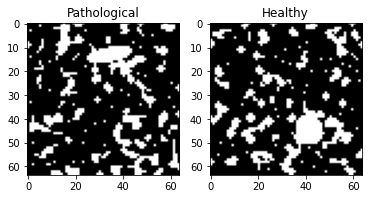

In [4]:
#display one pathological and one healthy image
fig, ax = plt.subplots(1,2)

path_img = imgs[:,:,np.where(labels == 0)[0][0]]
healthy_img = imgs[:,:,np.where(labels ==1)[0][0]]

ax[0].imshow(path_img, cmap=plt.cm.gray)
ax[1].imshow(healthy_img, cmap=plt.cm.gray)

ax[0].set_title("Pathological");
ax[1].set_title("Healthy");

In [5]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.expand_dims(imgs, -1)
X = np.transpose(X, (2,1,0,3))
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape

(4000, 64, 64, 1)

In [6]:
# Model hyperparameters
num_classes = 2
input_shape = (size, size, 1)
batch_size = 64
epochs = 40
conv_size=(3,3)
save = True
# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [7]:
#create model

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=conv_size, activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=conv_size, activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64)       256       
 hNormalization)                                                 
                                                        

In [8]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/40
38/38 [==============================] - 6s 131ms/step - loss: 1.9205 - accuracy: 0.5100 - val_loss: 0.6969 - val_accuracy: 0.4925
Epoch 2/40
38/38 [==============================] - 5s 119ms/step - loss: 1.3804 - accuracy: 0.5817 - val_loss: 0.7774 - val_accuracy: 0.5075
Epoch 3/40
38/38 [==============================] - 5s 120ms/step - loss: 1.1402 - accuracy: 0.6414 - val_loss: 0.9079 - val_accuracy: 0.5112
Epoch 4/40
38/38 [==============================] - 5s 119ms/step - loss: 1.0385 - accuracy: 0.6638 - val_loss: 1.1075 - val_accuracy: 0.5112
Epoch 5/40
38/38 [==============================] - 4s 118ms/step - loss: 0.9228 - accuracy: 0.7027 - val_loss: 0.9675 - val_accuracy: 0.5224
Epoch 6/40
38/38 [==============================] - 5s 119ms/step - loss: 0.7700 - accuracy: 0.7425 - val_loss: 1.0074 - val_accuracy: 0.5075
Epoch 7/40
38/38 [==============================] - 5s 119ms/step - loss: 0.6276 - accuracy: 0.7927 - val_loss: 0.9273 - val_accuracy: 0.5261
Epoch 

In [38]:
if save:
    model.save("models/model40_big_e_vs_c")

INFO:tensorflow:Assets written to: models/model40_big_e_vs_c\assets


INFO:tensorflow:Assets written to: models/model40_big_e_vs_c\assets


In [39]:
model = tf.keras.models.load_model("models/model40_big_e_vs_c")

In [9]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['Pathological', 'Healthy']

score = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(X_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.1549157053232193
Test accuracy: 0.9530302882194519
42/42 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

Pathological       1.00      0.91      0.95       654
     Healthy       0.91      1.00      0.96       666

    accuracy                           0.95      1320
   macro avg       0.96      0.95      0.95      1320
weighted avg       0.96      0.95      0.95      1320



In [10]:
import ipywidgets as widgets
#get array or predictions for test set

predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)


label_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1)],
    value=0,
    description='True Label:',
)
pred_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1)],
    value=0,
    description='Predicted Label:',
)
#pick what you want to see
display(label_picker)
display(pred_picker)


42/42 [==============================] - 1s 19ms/step


Dropdown(description='True Label:', options=(('Pathological', 0), ('Healthy', 1)), value=0)

Dropdown(description='Predicted Label:', options=(('Pathological', 0), ('Healthy', 1)), value=0)

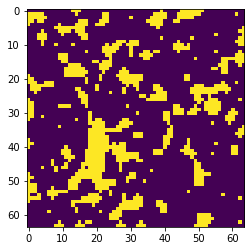

In [32]:
#show image
img = X_test[np.where((y_test == label_picker.value) & (predicted_classes == pred_picker.value))[0][1]]
plt.imshow(img)

In [40]:
heatmap = explainabilityModels.make_gradcam_heatmap(img, model)

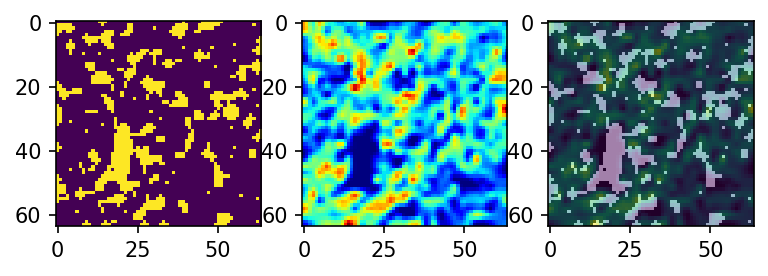

In [46]:
fig, ax = plt.subplots(1,3)
fig.set_dpi(150)
fig.tight_layout

ax[0].imshow(img)
ax[1].imshow(heatmap, cmap = 'jet')
ax[2].imshow(img, cmap = 'gray')
ax[2].imshow(heatmap, alpha = 0.5)
